In [98]:
import os
import pandas as pd
import numpy as np
from numpy import linalg as LA
import nltk
from alive_progress import alive_bar
import math
nltk.download('punkt')

ROOT_DIR = os.path.dirname(os.path.abspath("__file__"))
PARENT_DIR = os.path.dirname(ROOT_DIR)
GUARDIAN_DIR = os.path.join(ROOT_DIR, "data", "Guardian.csv")
REUTERS_DIR = os.path.join(ROOT_DIR, "data", "Reuters.csv")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Arthur\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


using norms

In [96]:
def load_glove_model(terms):
    common_vectors = []
    with open(os.path.join(ROOT_DIR, "glove_data", "results", "vectors.txt"), "r") as f:
        for line in f:
            if line.split(None, 1)[0] in terms:
                common_vectors.append(line.replace("\n", ""))

    glove_model = {}
    for line in common_vectors:
        split_line = line.split()
        word = split_line[0]
        embedding = np.array(split_line[1:], dtype=np.float64)
        glove_model[word] = embedding
    return glove_model


def article_index(article_text):

    # dictionaries
    economic_terms = ["economy", "economic"]
    uncertainty_terms = []
    with open(os.path.join(ROOT_DIR, "data", "Uncertainty.txt"), "r") as f:
        for line in f:
            uncertainty_terms.append(line.lower().replace("\n", ""))
    article_vocab = [word.lower() for word in nltk.word_tokenize(article_text) if word.isalpha()]

    common_uncertainty_terms = list(set(article_vocab).intersection(uncertainty_terms))
    common_economic_terms = list(set(article_vocab).intersection(economic_terms))

    if len(common_economic_terms) == 0 or len(common_uncertainty_terms) == 0:
        return None

    # index
    common_uncertainty_vectors = load_glove_model(common_uncertainty_terms)
    common_economic_vectors = load_glove_model(common_economic_terms)

    common_uncertainty_matrix = np.array(list(common_uncertainty_vectors.values()))
    common_economic_matrix = np.array(list(common_economic_vectors.values()))

    norm_uncertainty_matrix = LA.norm(common_uncertainty_matrix)
    norm_economic_matrix = LA.norm(common_economic_matrix)

    sum_common_uncertainty_terms = np.sum(common_uncertainty_matrix, axis=0)
    sum_common_economic_terms = np.sum(common_economic_matrix, axis=0)

    inner = (sum_common_economic_terms / norm_economic_matrix) - (sum_common_uncertainty_terms / norm_uncertainty_matrix)
    index = 1 / LA.norm(inner)

    return index


def daily_index(dataframe):

    data = pd.DataFrame(columns=["Date", "Text", "Norm", "Uncertainty"])
    text = ""
    date = dataframe.iloc[0, 0]
    for i in range(0, len(dataframe) ):
        if dataframe.loc[i, "Date"] == date:
            text += dataframe.loc[i, "Text"]
        else:
            data.loc[i - 1, "Text"] = text
            data.loc[i - 1, "Date"] = date
            text = ""
            date = dataframe.loc[i, "Date"]

    with alive_bar(len(data), title="→ Calculating daily norms", spinner="dots_waves", bar="smooth", force_tty=True) as bar:
        for i in range(0, len(data) ):
            daily_vocab = [word.lower() for word in nltk.word_tokenize(data.iloc[i, 1]) if word.isalpha()]
            daily_vectors = load_glove_model(daily_vocab)
            daily_matrix = np.array(list(daily_vectors.values()))
            daily_norm = LA.norm(daily_matrix)
            data.iloc[i, 2] = daily_norm
            bar()

    with alive_bar(len(dataframe), title="→ Calculating indexes", spinner="dots_waves", bar="smooth", force_tty=True) as bar:
        date = dataframe.iloc[0, 0]
        index = 0
        for i in range(0, len(dataframe)):
            if dataframe.loc[i, "Date"] == date:
                _ = article_index(dataframe.loc[i, "Text"])
                if _ is not None:
                    index += _
            else:
                data.loc[i - 1, "Uncertainty"] = index / data.loc[i - 1, "Norm"]
                index = 0
                date = dataframe.loc[i, "Date"]
            bar()

    data = data.drop(columns='Norm')
    return data


In [ ]:
guardian = pd.read_csv(GUARDIAN_DIR)
guardian_index = daily_index(guardian)
guardian_index['Date'] = pd.to_datetime(guardian_index['Date'])
guardian_index.set_index('Date',inplace=True,drop=True)
guardian_index.head()

using means

In [105]:
def load_glove_model(terms):
    common_vectors = []
    with open(os.path.join(ROOT_DIR, "glove_data", "results", "vectors.txt"), "r",encoding='utf8') as f:
        for line in f:
            if line.split(None, 1)[0] in terms:
                common_vectors.append(line.replace("\n", ""))

    glove_model = {}
    for line in common_vectors:
        split_line = line.split()
        word = split_line[0]
        embedding = np.array(split_line[1:], dtype=np.float64)
        glove_model[word] = embedding
    return glove_model


def article_index(article_text):

    # dictionaries
    economic_terms = ["economy", "economic"]
    uncertainty_terms = []
    with open(os.path.join(ROOT_DIR, "data", "Uncertainty.txt"), "r") as f:
        for line in f:
            uncertainty_terms.append(line.lower().replace("\n", ""))
    article_vocab = [word.lower() for word in nltk.word_tokenize(article_text) if word.isalpha()]

    common_uncertainty_terms = list(set(article_vocab).intersection(uncertainty_terms))
    common_economic_terms = list(set(article_vocab).intersection(economic_terms))

    if len(common_economic_terms) == 0 or len(common_uncertainty_terms) == 0:
        return None

    # index
    common_uncertainty_vectors = load_glove_model(common_uncertainty_terms)
    common_economic_vectors = load_glove_model(common_economic_terms)

    common_uncertainty_matrix = np.array(list(common_uncertainty_vectors.values()))
    common_economic_matrix = np.array(list(common_economic_vectors.values()))

    mean_common_uncertainty_terms = np.mean(common_uncertainty_matrix, axis=0)
    mean_common_economic_terms = np.mean(common_economic_matrix, axis=0)

    index = 1 / LA.norm((mean_common_economic_terms) - (mean_common_uncertainty_terms))

    return index

def normalize_index(dataframe):
    indexes = dataframe["Index"].values.tolist()
    largest = max(indexes)
    smallest = min(indexes)
    denom = largest-smallest
    new_indexes = [(x-smallest)/denom for x in indexes]
    dataframe["Index"] = new_indexes

    return dataframe

def dataframe_index(dataframe):

    indexes = []
    dates = []
    with alive_bar(len(dataframe), title="→ Calculating indexes", spinner="dots_waves", bar="smooth", force_tty=True) as bar:
        for i in range (0,len(dataframe)):
            bar()
            _ = article_index(dataframe.iloc[i,3])
            if _ is not None:
                indexes.append(_)
                dates.append(dataframe.iloc[i,0])
    
    unc_df = pd.DataFrame({'Date':dates,'Index':indexes})
    unc_df.set_index('Date')
    unc_df['Date'] = pd.to_datetime(unc_df['Date'])
    unc_df = normalize_index(unc_df)

    return unc_df


In [ ]:
guardian = pd.read_csv(GUARDIAN_DIR)
reuters = pd.read_csv(REUTERS_DIR)

guardian_index = dataframe_index(guardian)
reuters_index = dataframe_index(reuters)
reuters_index_davg = reuters_index.resample('D', on='Date').mean()
guardian_index_davg = guardian_index.resample('D', on='Date').mean()


In [108]:

import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import datetime as dt
def scatter_plot(data,title,xlabel,ylabel):

       fig, ax = plt.subplots(figsize=(25, 3))

       beginning = dt.date(2022, 1, 1)
       end = dt.date.today()

       ax.plot(data.index.values,
              data['Index'],
              color='purple',
              #linewidths=0
              )

       ax.set(
              #xlabel=xlabel,
              #ylabel=ylabel,
              title=title
              )

       date_form = DateFormatter("%m-%y")
       ax.xaxis.set_major_formatter(date_form)
       ax.set_xbound(beginning, end)

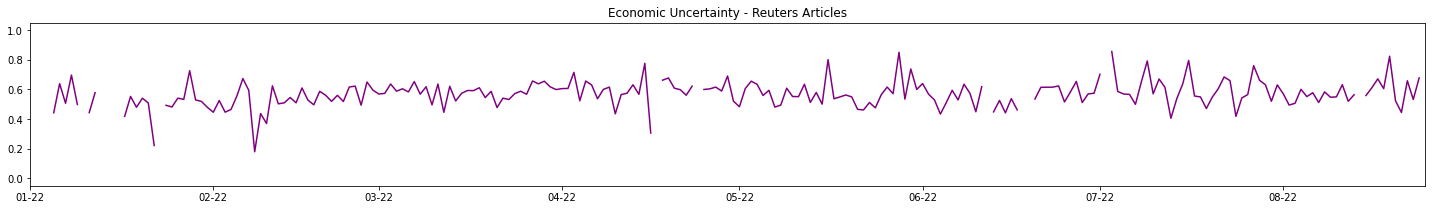

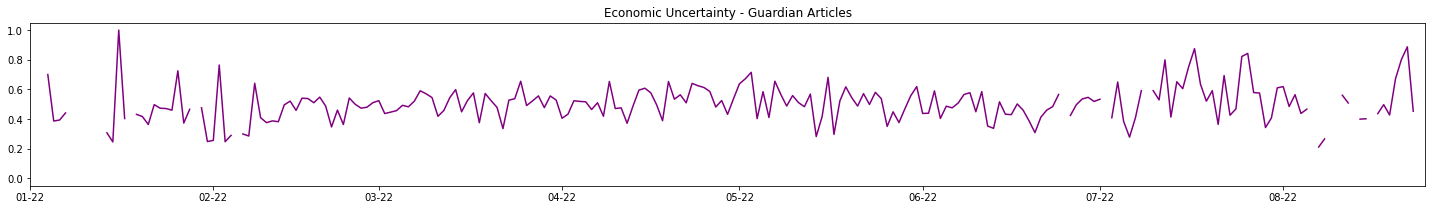

In [111]:
# using norms then davg
scatter_plot(reuters_index_davg,"Economic Uncertainty - Reuters Articles","","")
scatter_plot(guardian_index_davg,"Economic Uncertainty - Guardian Articles","","")

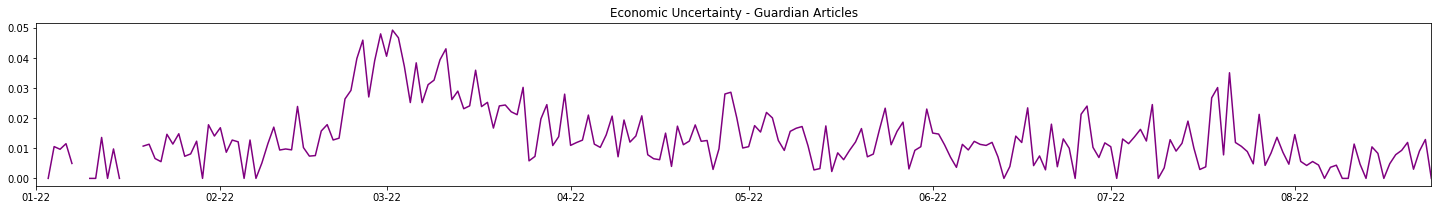

In [ ]:
# using norms then norms
scatter_plot(guardian_index,"Economic Uncertainty - Guardian Articles","","")